# Supply trend with market rates
This is an example combining functionality from our *Voyages*, *Market Rates* and *Tonnage List* APIs. The aim of the example is to plot a supply trend with superimposed, predicted market rates, in order to get a hollistic view of market behaviour during a specific period, for a specific load port, and a specific vessel class.

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Combined%20Examples/Supply%20trend%20with%20market%20rates.ipynb) 

## Setup
Install the Signal Ocean SDK:

In [3]:
!pip install signal-ocean


[notice] A new release of pip available: 22.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import required dependencies:

In [4]:
from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt

from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.market_rates import MarketRatesAPI
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
    IndexLevel,
    DateRange,
)


Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and use it to create a `Connection`:

In [5]:
signal_ocean_api_key = ""  # replace with your subscription key
connection = Connection(signal_ocean_api_key)


Create instances of APIs used throughout this notebook:

In [6]:
voyage_api = VoyagesAPI(connection)
tonnage_list_api = TonnageListAPI(connection)
market_rate_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend with the predicted market rates, we need to specify the following parameters for our queries:
1. `vessel_class` - the class of queried vessels.
1. `load_port` - the loading port.
1. `days_back` - the number of days the supply trend should reach back, starting from the current date.
1. `laycan_end_in_days` - the maximum estimated time of arrival for available vessels to reach the loading port.
1. `push_type` - the vessels' push status, if available from the emails in your account.
1. `market_deployment` - the vessels' market deployment. 
1. `commercial_status` - commercial status of the vessels at each point in time.
1. `vessel_subclass` - the type of oil product the vessel is classified to carry.
1. `ais_since` - how many days since the vessel has transmitted its AIS data.
1. `route_description` - the route of interest with available market rates.

In [7]:
vessel_class_filter = VesselClassFilter(name_like="Aframax")
load_port_filter = PortFilter(name_like="Ceyhan")
days_back = 90
laycan_end_in_days = 10

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED_POSS, PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.ON_SUBS,
        CommercialStatus.FAILED,
        CommercialStatus.CANCELLED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)

route_description = "Afra - BSea/Med"

today = date.today()
start_date = today - timedelta(days=days_back)
end_date = today


For more information, see the [Tonnage List](../../../../tonnage_list) and  [Market Rate](../../../../market_rates) API sections.

## Retrieve the historical tonnage list

In [8]:
vessel_class = tonnage_list_api.get_vessel_classes(vessel_class_filter)[0]
load_port = tonnage_list_api.get_ports(load_port_filter)[0]

htl = tonnage_list_api.get_historical_tonnage_list(
    load_port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, end_date),
    vessel_filter,
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend


name vessel_class ice_class  \
date                      imo                                               
2022-11-22 12:00:00+00:00 9592305     Nissos Delos      Aframax       NaN   
                          9330599          Lambada      Aframax       NaN   
                          9262924          Linda I      Aframax       NaN   
                          9389966           Alexia      Aframax       NaN   
                          9434890          PS Pisa      Aframax       NaN   
...                                            ...          ...       ...   
2022-08-24 12:00:00+00:00 9382762   Minerva Sophia      Aframax       NaN   
                          9373656          Seastar      Aframax       NaN   
                          9436020  Crude Centurion      Aframax       NaN   
                          9645401       Affinity V      Aframax       NaN   
                          9439383        PS Genova      Aframax       NaN   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2022-11-22 12:00:00+00:00 9592305        2012      115691          248.97   
                          9330599        2006      104866          243.56   
                          9262924        2002      104403          241.00   
                          9389966        2009      107574          243.80   
                          9434890        2010      108835          243.00   
...                                       ...         ...             ...   
2022-08-24 12:00:00+00:00 9382762        2009      115748          248.96   
                          9373656        2008      116050          248.96   
                          9436020        2010      112871          249.96   
                          9645401        2016      114070          252.00   
                          9439383        2010      108983          243.00   

                                   breadth_extreme subclass  \
date                      imo                                 
2022-11-22 12:00:00+00:00 9592305               44    Dirty   
                          9330599               44    Dirty   
                          9262924               42    Dirty   
                          9389966               42    Dirty   
                          9434890               42    Dirty   
...                                            ...      ...   
2022-08-24 12:00:00+00:00 9382762               44    Dirty   
                          9373656               44    Dirty   
                          9436020               44    Dirty   
                          9645401               45    Dirty   
                          9439383               42    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2022-11-22 12:00:00+00:00 9592305                            Spot   
                          9330599                            Spot   
                          9262924                           Relet   
                          9389966                            Spot   
                          9434890                            Spot   
...                                                           ...   
2022-08-24 12:00:00+00:00 9382762                            Spot   
                          9373656                            Spot   
                          9436020                            Spot   
                          9645401                            Spot   
                          9439383                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2022-11-22 12:00:00+00:00 9592305                  Pushed  ...   
                          9330599                  Pushed  ...   
                          9262924                  Pushed  .

## Get daily market rates for the route
We'll need a helper function to find our desired route for the market rates:

In [9]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = market_rate_api.get_routes(vessel_class_id=vessel_class.id)
    for i, v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]


Which we can use to find the route object returned from the Market Rates API:

In [10]:
market_rate_route = return_selected_route(vessel_class, route_description)


And use it to query for market rates:

In [11]:
market_rates = market_rate_api.get_market_rates(
    start_date,
    route_id=market_rate_route.id,
    vessel_class_id=vessel_class.id,
    end_date=end_date,
    cargo_id=market_rate_route.cargo_id
)

market_rates = pd.DataFrame([vars(vr) for vr in market_rates])
market_rates["rate_date"] = pd.to_datetime(market_rates["rate_date"])
market_rates.set_index("rate_date", inplace=True)
market_rates


,route_id,rate_value,unit,vessel_class_id,deprecated_to
rate_date,,,,,
2022-08-24,R1,192.5,WS,86,None
2022-08-25,R1,200.0,WS,86,None
2022-08-26,R1,205.0,WS,86,None
2022-08-27,R1,205.0,WS,86,None
2022-08-28,R1,205.0,WS,86,None
...,...,...,...,...,...
2022-11-18,R1,387.5,WS,86,None
2022-11-19,R1,387.5,WS,86,None
2022-11-20,R1,387.5,WS,86,None


## Plot the daily supply trend with market rates

C:\Users\Kimon\AppData\Local\Temp\ipykernel_4876\1394344043.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


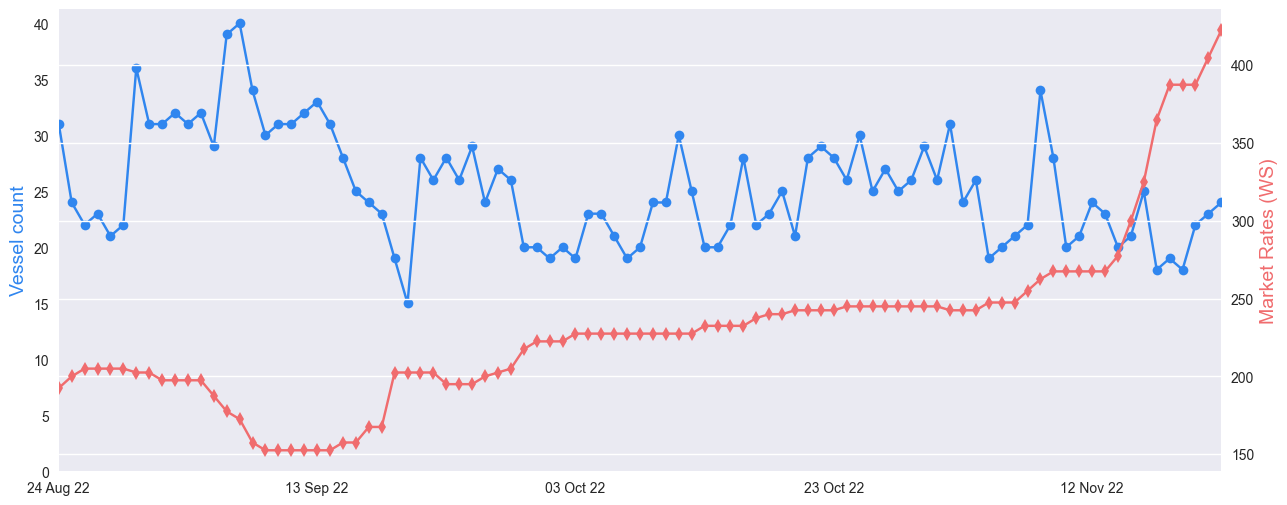

In [12]:
plt.style.use("seaborn")
fig, axs = plt.subplots(figsize=(15, 6))

supply_trend = htl_for_supply_trend.groupby(IndexLevel.DATE, sort=True).size()
supply_trend.index = supply_trend.index.strftime("%d %b %y")

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs, x="date", color="#3086EF", marker="o")
supply_plot.set_ylabel(
    "Vessel count", color=plt.gca().lines[-1].get_color(), fontsize=14
)
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
market_rates.index = market_rates.index.strftime("%d %b %y")
mr_plot = market_rates.plot(
    ax=axs, y="rate_value", secondary_y=True, color="#F06C6E", marker="d"
)
mr_plot.set_ylabel(
    "Market Rates (WS)", color=plt.gca().lines[-1].get_color(), fontsize=14
)

axs.set_xlim(0, len(supply_trend) - 1)
axs.set_xlabel("")
axs.get_legend().remove()


## Perform a point-to-point comparison

Here's an example of a workflow to compare two different points in time.

Specify the dates to compare:

In [13]:
point_a = today - timedelta(days=1)
point_b = today - timedelta(days=5)


In [14]:
dates = htl_for_supply_trend.index.get_level_values("date").date

if not any(dates == point_a):
    raise ValueError("Point A is not within imported date values.")
elif not any(dates == point_b):
    raise ValueError("Point B is not within imported date values.")

vessels_in_a = htl_for_supply_trend.loc[(dates == point_a)]
vessels_in_b = htl_for_supply_trend.loc[(dates == point_b)]


### Intersection of Vessel IMOs

In [15]:
intersection = pd.merge(
    vessels_in_a.add_suffix("_IN_A"),
    vessels_in_b.add_suffix("_IN_B"),
    how="inner",
    on="imo",
)

intersection


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_operator_point_in_time_IN_B,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B
imo,,,,,,,,,,,,,,,,,,,,,
9262924,Linda I,Aframax,NaN,2002,104403,241.00,42,Dirty,Relet,Pushed,...,Unknown,Available,2022-11-19 15:00:00+00:00,2022-11-17 11:03:23+00:00,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source
9370848,Anafi Warrior,Aframax,NaN,2009,107593,243.80,42,Dirty,Spot,Pushed,...,Polembros Shipping,Available,2022-11-22 06:00:00+00:00,2022-11-17 10:23:45+00:00,Narrow Area,Italy,Central Mediterranean,Mediterranean,Source,Source
9408530,Southport,Aframax,NaN,2008,115462,249.99,44,Dirty,Spot,Pushed,...,Active Shipping,Available,2022-11-19 21:00:00+00:00,2022-11-17 10:22:55+00:00,Narrow Area,Turkey,Sea of Marmara,Black Sea / Sea Of Marmara,Source,Source
9259707,Marianna V.V.,Aframax,NaN,2002,84999,238.94,38,Dirty,Relet,Pushed,...,Avin International,Available,2022-11-26 17:00:00+00:00,2022-11-17 10:25:33+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source
9377779,Monterey,Aframax,NaN,2007,105009,243.80,42,Dirty,Spot,Pushed POSS,...,Cardiff Marine,Available,2022-11-27 22:00:00+00:00,2022-11-17 09:53:42+00:00,Port,Turkey,East Mediterranean,Mediterranean,Source,Prediction
9439383,PS Genova,Aframax,NaN,2010,108983,243.00,42,Dirty,Spot,Pushed POSS,...,Scorpio Commercial Management,Available,2022-11-23 21:00:00+00:00,2022-11-17 10:37:31+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Prediction
9271377,Trident Hope,Aframax,NaN,2003,105985,241.03,42,Dirty,Spot,Pushed,...,New Shipping,Available,2022-11-23 13:00:00+00:00,2022-11-17 10:22:30+00:00,Port,Italy,Central Mediterranean,Mediterranean,Source,Source
9276597,Minerva Lisa,Aframax,1C,2004,103755,243.57,42,Dirty,Spot,Pushed POSS,...,Minerva Marine,Available,2022-11-23 18:00:00+00:00,2022-11-17 02:42:36+00:00,Narrow Area,Romania,Black Sea,Black Sea / Sea Of Marmara,Source,Source
9785720,Aquasurazo,Aframax,NaN,2017,113032,244.00,43,Dirty,Relet,Pushed,...,Mercuria,Available,2022-11-26 01:00:00+00:00,2022-11-17 10:02:52+00:00,Port,Spain,West Mediterranean,Mediterranean,Source,Prediction


### Difference between vessel IMOs in relation to point A

In [16]:
vessels_in_a_but_not_in_b = (
    vessels_in_a.add_suffix("_IN_A")
    .merge(
        vessels_in_b.add_suffix("_IN_B"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_a_but_not_in_b


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,commercial_status_point_in_time_IN_B,eta_point_in_time_IN_B,latest_ais_point_in_time_IN_B,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9285835,Wonder Polaris,Aframax,NaN,2005,115340,249.87,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9332810,P. Fos,Aframax,NaN,2007,115577,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9765029,Searunner,Aframax,1C,2017,114129,250.00,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9343340,Gemini Sun,Aframax,NaN,2008,115577,243.80,42,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9382762,Minerva Sophia,Aframax,NaN,2009,115748,248.96,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9777931,Ryman,Aframax,1A,2017,112870,250.00,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9773753,Seacalm,Aframax,NaN,2017,112119,237.00,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9364215,Nectar Sea,Aframax,NaN,2008,105370,228.60,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9297333,Minerva Clara,Aframax,1A,2006,103232,244.00,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMOs in relation to point B

In [17]:
vessels_in_b_but_not_in_a = (
    vessels_in_b.add_suffix("_IN_B")
    .merge(
        vessels_in_a.add_suffix("_IN_A"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_b_but_not_in_a


,name_IN_B,vessel_class_IN_B,ice_class_IN_B,year_built_IN_B,deadweight_IN_B,length_overall_IN_B,breadth_extreme_IN_B,subclass_IN_B,market_deployment_point_in_time_IN_B,push_type_point_in_time_IN_B,...,commercial_status_point_in_time_IN_A,eta_point_in_time_IN_A,latest_ais_point_in_time_IN_A,open_prediction_accuracy_point_in_time_IN_A,open_country_point_in_time_IN_A,open_narrow_area_point_in_time_IN_A,open_wide_area_point_in_time_IN_A,availability_port_type_point_in_time_IN_A,availability_date_type_point_in_time_IN_A,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9388364,Merbabu,Aframax,NaN,2008,105746,243.97,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9337901,Kriti Galaxy,Aframax,NaN,2006,110802,245.50,42,Dirty,Relet,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9776767,Tigani,Aframax,1A,2017,113000,249.89,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9783007,Nordpenguin,Aframax,NaN,2018,112038,237.00,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9773765,Seacharm,Aframax,NaN,2018,112179,238.97,44,Dirty,Spot,Pushed POSS,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9299733,Antaios,Aframax,NaN,2006,106094,243.96,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9857468,Seatribute,Aframax,NaN,2020,111890,237.00,44,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9420631,Karavas,Aframax,NaN,2010,107505,243.80,42,Dirty,Spot,Pushed,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,left_only
